In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
LEARNING_RATE = 1e-3


from iwae_torch import IWAE, VAE, Binarized_MNIST, train

BATCH_SIZE = 128
NUM_EPOCHS = 50
NUM_SAMPLES_LIST = [1, 10, 50]  # k values for importance weighting

MNIST_SIZE = 28

# Load dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = Binarized_MNIST("./data", train=True, download=True, transform=transform)

results = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




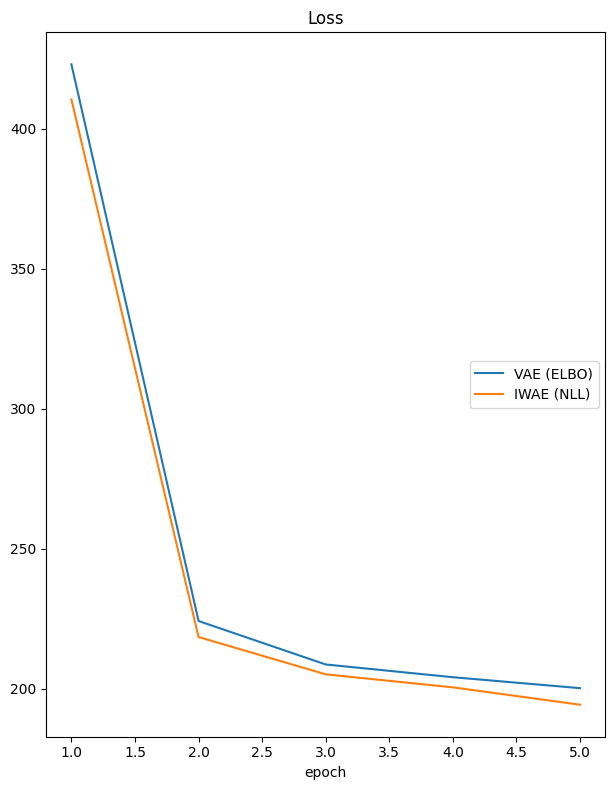

Loss
	VAE (ELBO)       	 (min:  200.273, max:  423.027, cur:  200.273)
	IWAE (NLL)       	 (min:  194.363, max:  410.500, cur:  194.363)
Finished training for k=50
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.22MB/s]


Extracting ./data\Binarized_MNIST\raw\train-images-idx3-ubyte.gz to ./data\Binarized_MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 174kB/s]


Extracting ./data\Binarized_MNIST\raw\train-labels-idx1-ubyte.gz to ./data\Binarized_MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 1.71MB/s]


Extracting ./data\Binarized_MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\Binarized_MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.55MB/s]
C:\Users\Andre\AppData\Local\Temp\ipykernel_61672\1941655823.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_mo

Extracting ./data\Binarized_MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\Binarized_MNIST\raw



ValueError: not enough values to unpack (expected 4, got 3)

In [2]:
def measure_active_units(model, data_loader, device):
    model.eval()
    all_latents = []
    with torch.no_grad():
        for x  in data_loader:
            x = x.to(device)
            _, mu_z, _ = model.encode(x, k=1)  # k=1 for single pass
            all_latents.append(mu_z.cpu())

    all_latents = torch.cat(all_latents, dim=0)
    variances = all_latents.var(dim=0)
    active_units = (variances > 1e-2).sum().item()
    return active_units

active_units_train = {}

for k in NUM_SAMPLES_LIST:
    print(f"Training IWAE and VAE with k={k}")
    vae_model = VAE(k).to(device)
    iwae_model = IWAE(k).to(device)

    # Train models
    trained_vae, trained_iwae = train(train_dataset, vae_model, iwae_model, NUM_EPOCHS)

    # Save models
    torch.save(trained_vae.state_dict(), f"vae_k{k}.pth")
    torch.save(trained_iwae.state_dict(), f"iwae_k{k}.pth")

    # measure active units
    vae_active_units = measure_active_units(trained_vae, DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False), device)
    iwae_active_units = measure_active_units(trained_iwae, DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False), device)

    active_units_train[k] = {
        "vae_active_units": vae_active_units,
        "iwae_active_units": iwae_active_units,
    }

    print(f"k={k}: VAE Active Units = {vae_active_units}, IWAE Active Units = {iwae_active_units}")

    print(f"Finished training for k={k}")

# Load test dataset
test_dataset = Binarized_MNIST("./data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

active_units_results = {}

for k in NUM_SAMPLES_LIST:
    vae_model = VAE(k).to(device)
    vae_model.load_state_dict(torch.load(f"vae_k{k}.pth"))
    iwae_model = IWAE(k).to(device)
    iwae_model.load_state_dict(torch.load(f"iwae_k{k}.pth"))

    vae_active_units = measure_active_units(vae_model, test_loader, device)
    iwae_active_units = measure_active_units(iwae_model, test_loader, device)

    active_units_results[k] = {
        "vae_active_units": vae_active_units,
        "iwae_active_units": iwae_active_units,
    }

    print(f"k={k}: VAE Active Units = {vae_active_units}, IWAE Active Units = {iwae_active_units}")

# Plot active units comparison
ks = list(active_units_results.keys())
vae_units = [active_units_results[k]["vae_active_units"] for k in ks]
iwae_units = [active_units_results[k]["iwae_active_units"] for k in ks]

plt.figure(figsize=(8, 4))
plt.plot(ks, vae_units, label="VAE Active Units", marker="o")
plt.plot(ks, iwae_units, label="IWAE Active Units", marker="o")
plt.title("Active Latent Dimensions")
plt.xlabel("k")
plt.ylabel("Number of Active Units")
plt.legend()
plt.show()